# FlexPower Quant Challenge

<mark>Diclaimer</mark>

- The initial code and logic were entirely developed by me. ChatGPT was later used to streamline code formatting and expedite the creation of polished, clean plots. (This sentence was also improved by ChatGPT)
- In order to keep this notebook readable, some of the plots, especially for task 2.7 where saved in the directory `results`. Please run the full notebook to reproduce the plots.

## Setup

The entire project can and should be run in the development container.

### Dev Container Setup
1. Docker Desktop must be installed. VSCode must be installed with the devcontainer extension.
2. In the project directory, run `docker compose build` to build the container. Run `docker compose up -d` to start the container. All required python packages will be installed during setup.
3. Open the project in VSCode (e.g. with `code .` in the project directory) and reopen the project in the devcontainer.

### Custom Setup

- _The setup was never tested outside of the Dev Container._
- In order to run the project in a custom environment, Python 3.12 should be used (exakt version used in the devcontainer is 3.12.7).
- All required packages can be found in `requirements.txt`.

## Task 1

- Task 1 was done using the fastAPI package. 
- The code can be found under `app/`. The code structure is based on an onion architectue.
- All 3 methods that were requested can be found in the `PnLService` (app/services/pnl_service.py), where all business logic is kept.
    - The requested method `get_pnl_by_strategy_id` is named `get_pnl_by_strategy_id_with_timestamp` in the service, since the timestamp gets created at the repository layer and needs to be processed through the service.
    - The logic of the requested methods is tested via pytest. The tests can be found in `app/tests/test_pnl_sercvice.py`.
- To start the api server, start fastAPI via `uvicorn app.main:app --host 0.0.0.0 --port 8000`. When using the devcontainer setup, this command needs to be run inside the container. The requested get endpoint (task 1.3) can be accesed via `http://localhost:8000/v1/pnl/{strategy_id}` once the application is running. The documentation of the full api can be found at `http://localhost:8000/openapi.json`.

## Task 2

The solution of task 2 can be found in this notebook. Only some of the plot are saved in the directory `results` instead of in the notebook.

### Setup

Package imports, file imports and renaming of columns.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import calendar

In [2]:
file_name = pd.ExcelFile("app/analysis_task_data.xlsx")

df = pd.read_excel(file_name, sheet_name=None)['DE_Wind_PV_Prices']

In [3]:
column_mapping = {
    "hour": "hour",
    "time": "timestamp",
    "Wind Day Ahead Forecast [in MW]": "da_wind",
    "Wind Intraday Forecast [in MW]": "intra_wind",
    "PV Day Ahead Forecast [in MW]": "da_pv",
    "PV Intraday Forecast [in MW]": "intra_pv",
    "Day Ahead Price hourly [in EUR/MWh]": "da_price",
    "Intraday Price Price Quarter Hourly  [in EUR/MWh]": "intra_price_15m",
    "Intraday Price Hourly  [in EUR/MWh]": "intra_price_1h",
    "Imbalance Price Quarter Hourly  [in EUR/MWh]": "imbalance_price_15m",
}

In [4]:
df.rename(columns=column_mapping, inplace=True)
df.set_index('timestamp', inplace=True)
df.drop(columns=["hour"], inplace=True)
df = df.sort_index()

### Task 2.0
Initial overview over the given dataset. Plotting every time series.

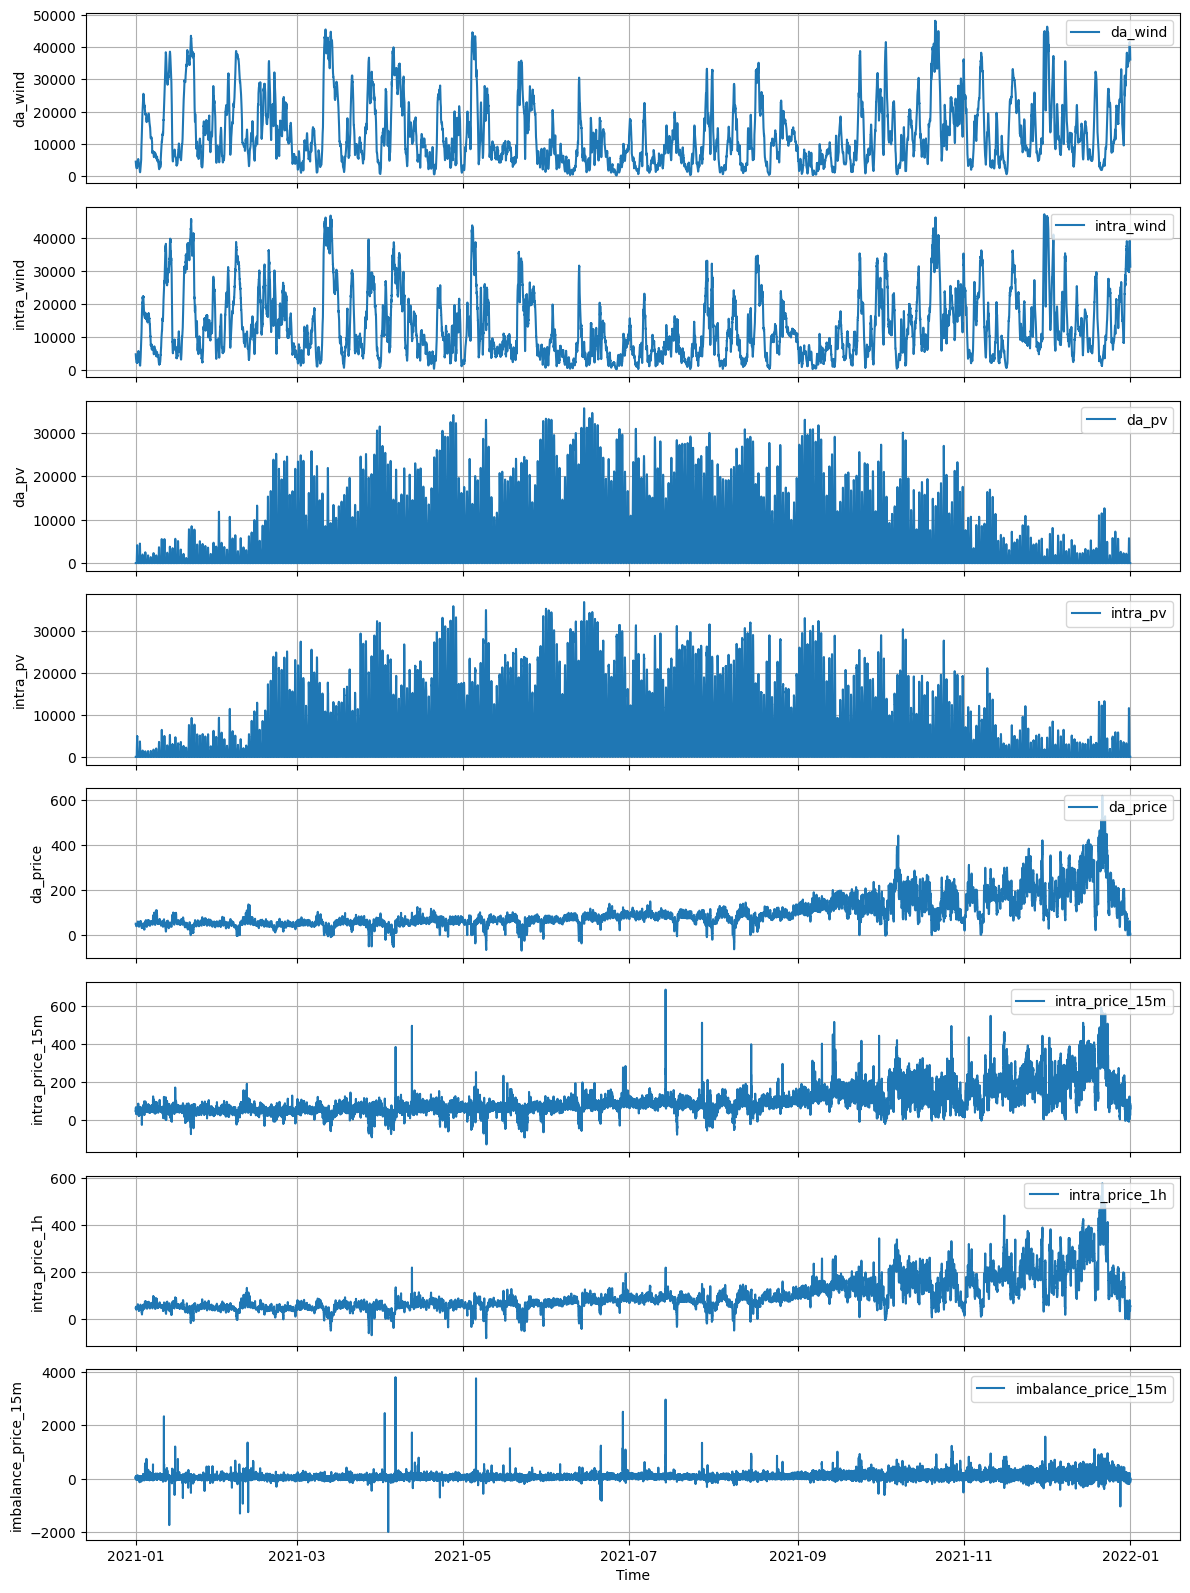

In [5]:
# Set up the subplots
n_plots = len(df.columns)
fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots * 2), sharex=True)

# Plot each column
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=column)
    ax.set_ylabel(column)
    ax.grid()
    ax.legend(loc="upper right")

# Set common x-axis label and adjust layout
axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()


### Task 2.1

How much Wind/PV Power was forecasted to produced in German in 2021 [in MWh] on Day Ahead (da) and on Intraday (id). Hint: Be careful: you have values in MW on a quarter hourly basis, think how this translates into hourly values.

**Answer + Notes:** 
- Since MW on a quarter hour basis, dividing by 4

Day-Ahead Wind Forecasted Generation  :  115.40 [TWh]
Intraday Wind Forecasted Generation   :  113.48 [TWh]
Day-Ahead PV Forecasted Generation    :   46.09 [TWh]
Intraday PV Forecasted Generation     :   46.69 [TWh]
Total Day-Ahead Forecasted Generation :  161.49 [TWh]
Total Intraday Forecasted Generation  :  160.17 [TWh]


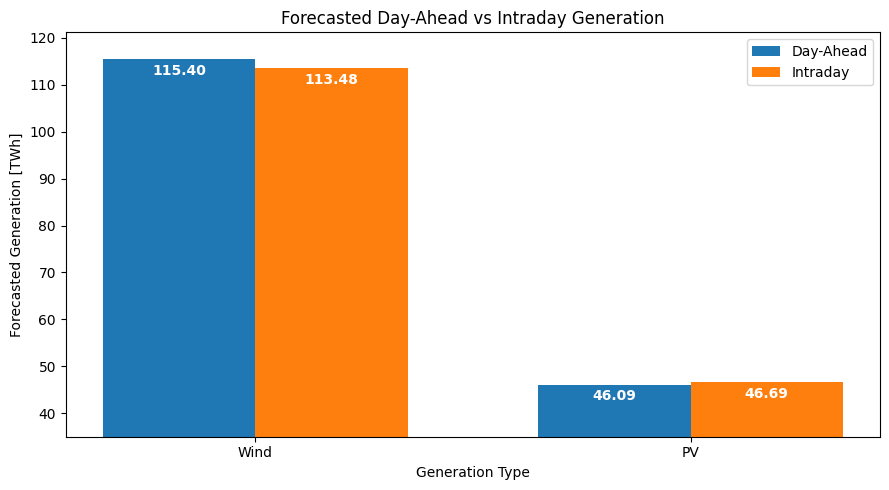

In [6]:
categories = ['Wind', 'PV']

# sum and convert into TWh
day_ahead_gen_forecast = [
    float(df['da_wind'].sum()) / 4 / 1_000_000,
    float(df['da_pv'].sum()) / 4 / 1_000_000,
]
intraday_gen_forecast = [
    float(df['intra_wind'].sum()) / 4 / 1_000_000,
    float(df['intra_pv'].sum()) / 4 / 1_000_000,
]

total_day_ahead = sum(day_ahead_gen_forecast)
total_intraday = sum(intraday_gen_forecast)

print(f"Day-Ahead Wind Forecasted Generation  : {day_ahead_gen_forecast[0]:>7.2f} [TWh]")
print(f"Intraday Wind Forecasted Generation   : {intraday_gen_forecast[0]:>7.2f} [TWh]")
print(f"Day-Ahead PV Forecasted Generation    : {day_ahead_gen_forecast[1]:>7.2f} [TWh]")
print(f"Intraday PV Forecasted Generation     : {intraday_gen_forecast[1]:>7.2f} [TWh]")
print(f"Total Day-Ahead Forecasted Generation : {total_day_ahead:>7.2f} [TWh]")
print(f"Total Intraday Forecasted Generation  : {total_intraday:>7.2f} [TWh]")

# Set up the bar plot
x = np.arange(len(categories))  # Label locations
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(x - width/2, day_ahead_gen_forecast, width, label='Day-Ahead')
bars2 = ax.bar(x + width/2, intraday_gen_forecast, width, label='Intraday')

# Add labels, title, and legend
ax.set_title('Forecasted Day-Ahead vs Intraday Generation')
ax.set_xlabel('Generation Type')
ax.set_ylabel('Forecasted Generation [TWh]')
ax.set_ylim(35)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for bar in bars1:
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() - 1,  # Position slightly below the top of the bar
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='top', 
        color='white', 
        fontweight='bold'
    )

for bar in bars2:
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() - 1,  # Position slightly below the top of the bar
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='top', 
        color='white', 
        fontweight='bold'
    )

# Show the plot
plt.tight_layout()
plt.show()


### Task 2.2

Show the average Wind/Solar production for 2021 over a 24h period for Intraday and Day Ahead (4 lines in one graph).

**Answer + Notes:** 
- Plotting mean for each hour of the day for the whole year
- Adding the same plot for the prices

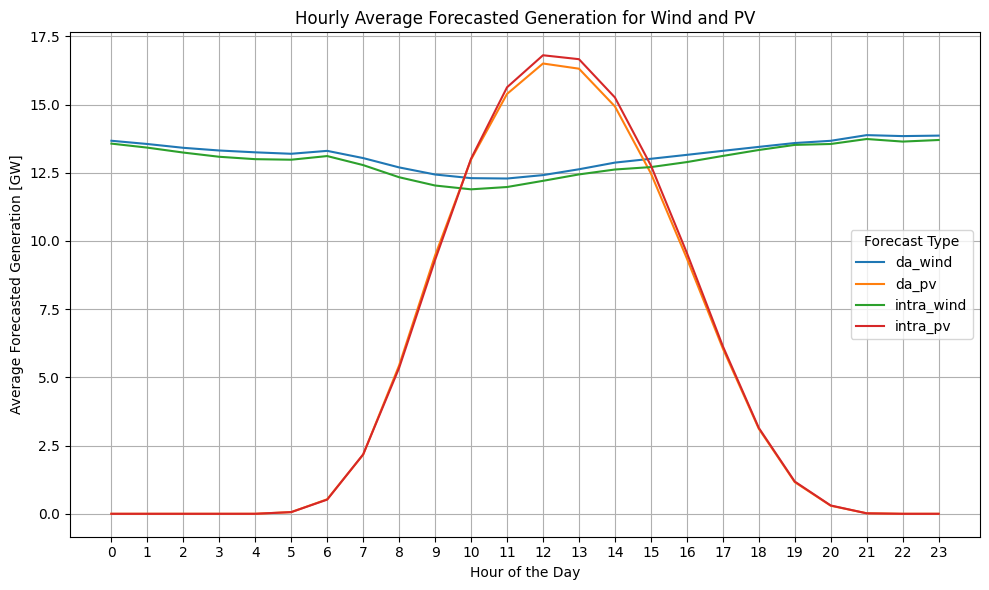

In [7]:
# Calculate the mean for each hour across all days and convert to GW
df_hourly_avg = df[['da_wind', 'da_pv', 'intra_wind', 'intra_pv']].groupby(df.index.hour).mean() / 1_000

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_hourly_avg.plot(ax=ax)

# Set labels and title
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Forecasted Generation [GW]')
ax.set_title('Hourly Average Forecasted Generation for Wind and PV')
ax.grid(True)
ax.legend(title="Forecast Type")
ax.set_xticks(range(0, 24))  # Ensure one tick per hour
plt.xticks(rotation=0)  # Keep hour labels horizontal for readability

# Show the plot
plt.tight_layout()
plt.show()

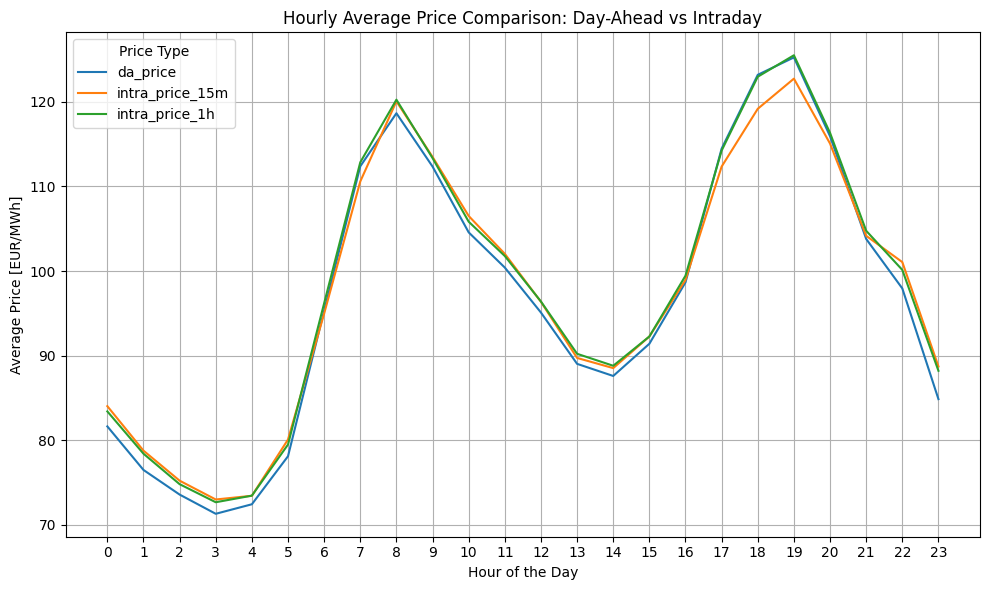

In [8]:
# Calculate the mean for each hour across all days
df_hourly_avg = df[['da_price', 'intra_price_15m', 'intra_price_1h']].groupby(df.index.hour).mean()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_hourly_avg.plot(ax=ax)

# Set labels and title
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Price [EUR/MWh]')
ax.set_title('Hourly Average Price Comparison: Day-Ahead vs Intraday')
ax.grid(True)
ax.legend(title="Price Type")
ax.set_xticks(range(0, 24))  # One tick per hour for clarity
plt.xticks(rotation=0)  # Keep hour labels horizontal

# Show the plot
plt.tight_layout()
plt.show()


### Task 2.3

What was the average value [in EUR/MWh] for Wind/Solar Power in 2021 using the da forecast and using da h prices? The average value is defined as the average hourly value that a Wind/PV farm owner would have received for their product. Is the average value of Wind and PV higher or lower than the average da price? Why could it be higher/lower?

**Answer + Notes:** 

Using the following formular:
$$\frac{\sum{(generation [15min] * price)}}{\sum{generation [15min]}}$$
The divivsions by 4 cancel out.

In [9]:
# Calculate the mean and weighted average values
mean_da_price = df['da_price'].mean()
weighted_avg_wind_price = (df['da_wind'] * df['da_price']).sum() / df['da_wind'].sum()
weighted_avg_pv_price = (df['da_pv'] * df['da_price']).sum() / df['da_pv'].sum()

# Print the results with consistent alignment and clear messages
print(f"{'Weighted Average Day-Ahead Price (Wind):':<40} {weighted_avg_wind_price:.2f} EUR/MWh")
print(f"{'Weighted Average Day-Ahead Price (PV):':<40} {weighted_avg_pv_price:.2f} EUR/MWh")
print(f"{'Overall Average Day-Ahead Price:':<40} {mean_da_price:.2f} EUR/MWh")

Weighted Average Day-Ahead Price (Wind): 81.39 EUR/MWh
Weighted Average Day-Ahead Price (PV):   76.89 EUR/MWh
Overall Average Day-Ahead Price:         96.85 EUR/MWh


The short answer is, that renewable generation units have smaller marginal costs, which is why they offer their generation for lower prices. Therefore, the price decreases with higher renewable generation availibility, because of the special functionality of the auction based day-ahead market.
 
The detailed answer explains why this effect occures in the day-ahead market.
 
The lower prices can be explained by one of the most common approximations of the day-ahead electricity market, the merit order model. In the merit order model, the load `L` is assumed to be only dependend on the time `t`, not on the price `p`. Therefore the demand is satisfied by generation units according to their marginal costs. All units with marginal costs below the market price `p` can realize positive contribution margins and are thus “on”, all others are “off”. Hence one can obtain an approximate view of the market outcome by sorting all generating units according to their estimated marginal costs. Since renewable generation has low variable costs, they offer their generation for lower prices than dispatchable generation, e.g. coal, gas or nuclear generation (which was still active in 2021). Since the price of the day-ahead auction, the market clearing price (MCP), is set by the highest price of the generation that still contributes, prices get lower if more expensive generation is not needed.
 
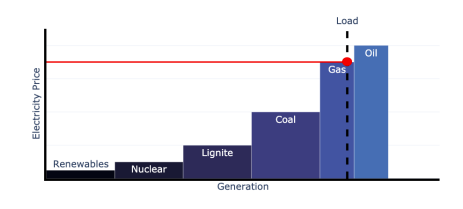
 
In the image, we see a generation mix, where gas generation sets the MCP. More renewable generation would now move all generation to the right, but since the load is inelastic (by assumption in the merit order model), the MCP would drop to the price of the next generation (coal) once gas generation is not needed to satisfy the load.

From the merit order model follows, that the Price `p` is proportianal to the residual load, the load minus all renewable generation, since the price only depends on the most expensive generation in the generaion mix. Therefore the price `p` is inverse proportional to the renewable generation.

$$Price \propto \text{Residual Load} \propto \frac{1}{\text{Renewable Generation}}$$

The merit order model does not take into account negative prices, which also usually occur for high renewable generation.

See the following [Paper](https://www.sciencedirect.com/science/article/pii/S2666546823000228), section 2.2 for more information about the merit order model.
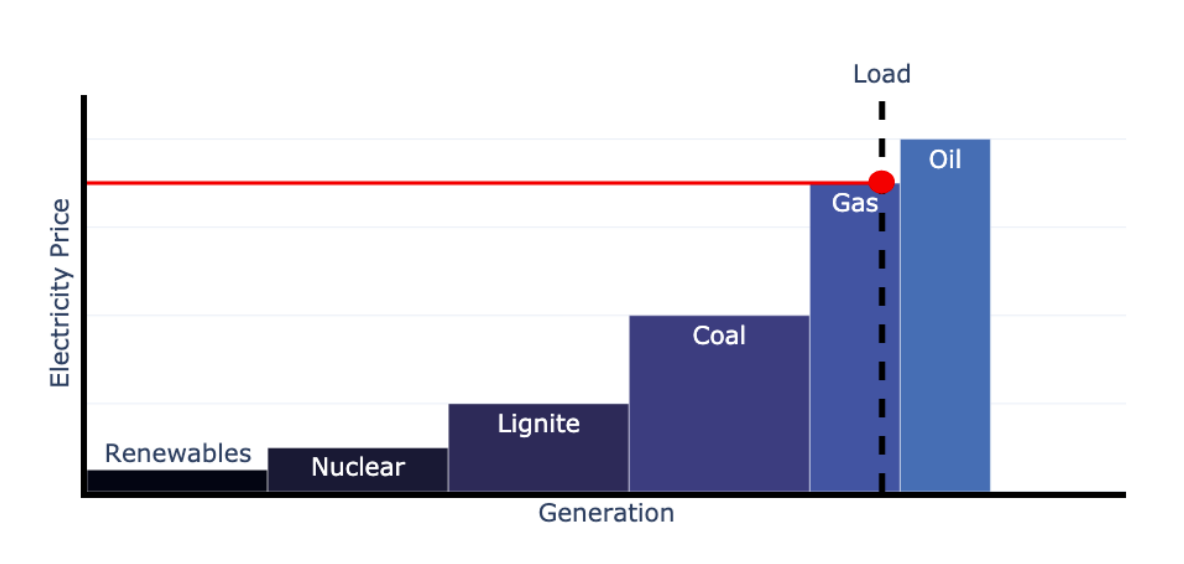

### Task 2.4

Find the Day with the highest renewable energy production and with the lowest renewable energy production in 2021. What was the average Day Ahead Price levels on these days? How do you explain the difference in prices?

In [10]:
# Calculate the daily renewable generation for day-ahead
df['da_daily_renew'] = (df['da_wind'] + df['da_pv']).resample('D').sum()

# Get timestamps for the maximum and minimum renewable generation days
max_renew_timestamp = df['da_daily_renew'].idxmax()
min_renew_timestamp = df['da_daily_renew'].idxmin()

# Retrieve the total renewable generation for max and min days
max_renew_value = df['da_daily_renew'][max_renew_timestamp]
min_renew_value = df['da_daily_renew'][min_renew_timestamp]

# Filter day-ahead prices for max and min renewable generation days
df_max_renew_day_price = df[df.index.date == max_renew_timestamp.date()]['da_price']
df_min_renew_day_price = df[df.index.date == min_renew_timestamp.date()]['da_price']

# Calculate mean prices
max_renew_mean_price = df_max_renew_day_price.sum() / 4 / 24
min_renew_mean_price = df_min_renew_day_price.sum() / 4 / 24

# Print results with timestamps and values
print(f"Max Renewable Generation Day: {max_renew_timestamp.date()} with {max_renew_value:.2f} MWh")
print(f"Min Renewable Generation Day: {min_renew_timestamp.date()} with {min_renew_value:.2f} MWh")
print(f"Average Day-Ahead Price on Max Renewable Day: {max_renew_mean_price:8.2f} EUR/MWh")
print(f"Average Day-Ahead Price on Min Renewable Day: {min_renew_mean_price:8.2f} EUR/MWh")

Max Renewable Generation Day: 2021-03-12 with 4352164.00 MWh
Min Renewable Generation Day: 2021-11-16 with 236797.00 MWh
Average Day-Ahead Price on Max Renewable Day:    22.29 EUR/MWh
Average Day-Ahead Price on Min Renewable Day:   237.47 EUR/MWh


See answer from task 2.3. The same explanation holds here.

### Task 2.5

What is the average hourly da price during week days vs during weekends. Why do you think average prices may differ?

In [11]:
# Identify weekends in the DataFrame
df['is_weekend'] = df.index.weekday >= 5

# Calculate mean day-ahead prices for weekdays and weekends
mean_weekday_price = df.loc[~df['is_weekend'], 'da_price'].mean()
mean_weekend_price = df.loc[df['is_weekend'], 'da_price'].mean()

# Print the results with clear labels
print(f"Mean Day-Ahead Price on Weekdays: {mean_weekday_price:.2f} EUR/MWh")
print(f"Mean Day-Ahead Price on Weekends: {mean_weekend_price:.2f} EUR/MWh")


Mean Day-Ahead Price on Weekdays: 104.37 EUR/MWh
Mean Day-Ahead Price on Weekends: 77.98 EUR/MWh


Since the daily profile of the price usually follows the daily profile of the load (see merit order model again for a simple explanation), high prices occur for high load, e.g. peak load which is in the morning and at the evening. On weekends the peak load and overall load is lower compared to the weekdays which is why prices tend to be lower on the weekends.

### Task 2.6

How much revenue would you generate with a battery with a capacity of 1 MWh which you can fully charge and fully discharge (1 Cycle) every day in 2021? Think about when you would charge and when you would discharge and apply this rule for each day of the year.

**Answer + Notes:** 
- Looking at the average hourly prices already plotted in task 2.2, there a obvious price peaks at peak load. The evening load being higher. The lowest load is usually during the night, which is why prices always tend to be low during the night. Taking the minumum average hourly price to buy and the maximum average hourly price to sell.

In [12]:
# Determine the optimal buy and sell hours based on average day-ahead price
buy_hour = int(df['da_price'].groupby(df.index.hour).mean().idxmin())
sell_hour = int(df['da_price'].groupby(df.index.hour).mean().idxmax())

# Filter the DataFrame for entries at the identified buy and sell hours
df_filtered = df[(df.index.hour == buy_hour) | (df.index.hour == sell_hour)][['da_price']]

# Pivot the DataFrame to have separate columns for buy and sell prices
df_pivoted = df_filtered.pivot_table(index=df_filtered.index.date, columns=df_filtered.index.hour, values='da_price')

# Rename columns to clearly indicate buy and sell prices, regardless of order
df_pivoted = df_pivoted.rename(columns={buy_hour: 'price_buy', sell_hour: 'price_sell'})

# Drop rows with missing values (in case any timestamps are missing)
df_pivoted = df_pivoted.dropna()

# Calculate the daily price difference (price_sell - price_buy)
df_pivoted['price_difference'] = df_pivoted['price_sell'] - df_pivoted['price_buy']

# Display the result
print(f"Optimal Buy Hour: {buy_hour:02d}:00, Sell Hour: {sell_hour:02d}:00")
print(f"Total Price Difference Sum: {df_pivoted['price_difference'].sum():.2f} EUR")


Optimal Buy Hour: 03:00, Sell Hour: 19:00
Total Price Difference Sum: 19695.44 EUR


### Task 2.7

Come up with a trading strategy that makes money between the day ahead hourly prices and the intraday hourly prices. A strategy could be something like, always buy hour 19-20 on day ahead and sell it on intraday. You can look at certain times, weekdays, seasons, production levels of wind and solar. Your strategy can have a few input paramters such as time, renewable production etc, and then a decision output between two prices. I.e. when do you want to go long and short. Show the cumulative performance of this strategy with a 100 MW position. Show your results and quickly explain your reasoning of why you think this strategy might be a good idea and why it does or does not work.

**Answer + Notes:**

Answer:

All steps of the detailed answer, the code for all plots, the testing method and the strategy methods are below in the next cells.

Short answer:
- I would choose a trading strategy based on the generation ramps to the following hour of the day-ahead forecasted wind generation that shorts the day-ahead market and buys back the position in the 15 minute intraday market. 

    ```py
    def buy_high_wind_ramp_out_15m_thresh_strat(df, threshold):

        strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

        strategy_df.loc[(df['da_wind_ramp_out'] >= threshold), 'strategy'] = "sell_15m"
        
        return strategy_df
    ```
    For a threshold of the generation ramp of 3GWh, the result is:

    ```
    Strategy: Wind Gen Ramp Out 15m, theshold=3000
	    Total Profit/Loss: 80k EUR
        Total Trade Count: 70
        Mean Profit/Loss: 1141 EUR
    ```

    Even though this strategy does not achieve the highest total profit it has the highest mean profit and it seems like the more stable strategy, since it is based on the physical constraints of generation ramping. Since physical constraints are unlikely to change quickly, the strategy should probably work for a longer time period.

Detailed answer and step by step analysis:
- This is a summary of the steps I did to analyse this task and come up with an answer.
- As a first step, I extend the dataset with additional features, like the total renewable generation or generation ramps.
    - Taking only the mean per hour for the day-ahead forecasts of wind and pv for simplicity.
- The difference between the day-ahead price and all other prices is calculated. The 15 minute intraday prices are analysed for each interval but also for their mean, since this is the price that needs to be bought/sold
- To get ideas for efficient strategies, I plot relations between most of the input features and the price differences. Extreme price differences in any direction should lead to a good strategy.
    - Most plots are saved into the directory `results`, which is not commited to keep the repo size small. Please run the notebook to generate all plots.
- The following strategies seem promising:
    - Looking at the mean price difference at each hour for weekdays and weekends, some hours have an average price difference of a around 3 EUR. Since this strategy could be traded each day, the total profit is high, even though the mean return stays low.
    - The mean price difference for higher forecasted wind generation is between around 5 and 7.5 EUR, which is higher than the strategy based on the hour and still yields enough trading opportunities to achieve a high total profit.
    - The mean price difference of Q4 of the 15 minute intraday market has a noticable difference of around -50 EUR (for a binning of the generation ramp into 1GWh) for higher ramps, especially for the ramp to the next hourly interval. The strategy achieves a high mean profit per trade of around 2500 EUR for ramps higher than 5GWh. The total profit becomes lower for higher mean profit, since higher ramps become less frequent.
- Which strategy to take?
    - I choose the strategy based on wind generation ramps to the next hour. It has the highest mean profit, meaning that each trade itself offers a good profitablilty and it has a good and logical explanation (see below). The strategy based on hours or the "always long" strategy seem like an easy strategy to make a lot of money, but they also feel to good to be true. This should not be possible in an efficient market.
    - Explanation for price difference: The day-ahead market is hourly based, which is why there can be ramps of multiple GW between hours, e.g. when weather changes occour. Since most non-renewable generation, like coal or nuclear generation, is not able to ramp down instantly, these power plants need to sell of their "ramp-down phase" during Q4, which makes prices drop in the intraday market for Q4.

Notes:
- Trade in both directions
- Close position in either 1h or 15m intra. Since 100 MW in da, then 100 MWh in 1h intraday and 25 MWh in 15m intraday
- Closing on 15m intraday means closing on Q1-4

#### Analysis (Plotting)

In [13]:
# resampling to hourly and creating extra columns for 15m intraday q1-4
df_hourly = df[['da_wind', 'da_pv', 'da_price', 'intra_price_1h']].resample('h').mean()

df_hourly['intra_price_15m_q1'] = df[df.index.minute == 0]['intra_price_15m'].resample('h').first()
df_hourly['intra_price_15m_q2'] = df[df.index.minute == 15]['intra_price_15m'].resample('h').first()
df_hourly['intra_price_15m_q3'] = df[df.index.minute == 30]['intra_price_15m'].resample('h').first()
df_hourly['intra_price_15m_q4'] = df[df.index.minute == 45]['intra_price_15m'].resample('h').first()

df_hourly['intra_price_15m_mean'] = df_hourly[['intra_price_15m_q1', 'intra_price_15m_q2', 'intra_price_15m_q3', 'intra_price_15m_q4']].mean(axis=1)

In [14]:
# add additional features for later usage
df_hourly['is_weekend'] = df_hourly.index.to_series().apply(lambda x: x.weekday() >= 5)
df_hourly['price_diff_1h'] = df_hourly['intra_price_1h'] - df_hourly['da_price']
df_hourly['price_diff_15m_q1'] = df_hourly['intra_price_15m_q1'] - df_hourly['da_price']
df_hourly['price_diff_15m_q2'] = df_hourly['intra_price_15m_q2'] - df_hourly['da_price']
df_hourly['price_diff_15m_q3'] = df_hourly['intra_price_15m_q3'] - df_hourly['da_price']
df_hourly['price_diff_15m_q4'] = df_hourly['intra_price_15m_q4'] - df_hourly['da_price']
df_hourly['price_diff_15m_mean'] = df_hourly['intra_price_15m_mean'] - df_hourly['da_price']

df_hourly['da_renew'] = df_hourly['da_wind'] + df_hourly['da_pv']

# in ramping
df_hourly['da_wind_ramp_in'] = df_hourly['da_wind'].diff()
df_hourly['da_pv_ramp_in'] = df_hourly['da_pv'].diff()
df_hourly['da_renew_ramp_in'] = df_hourly['da_renew'].diff()

# out ramping (hour 23 ramp could be onknown at da 12h)
df_hourly['da_wind_ramp_out'] = df_hourly['da_wind'].shift(-1) - df_hourly['da_wind']
df_hourly['da_pv_ramp_out'] = df_hourly['da_pv'].shift(-1) - df_hourly['da_pv']
df_hourly['da_renew_ramp_out'] = df_hourly['da_renew'].shift(-1) - df_hourly['da_renew']


In [15]:
# drop nans that occur because of daylight saving
df_hourly.dropna(inplace=True)

##### 1h DA vs Intra Price

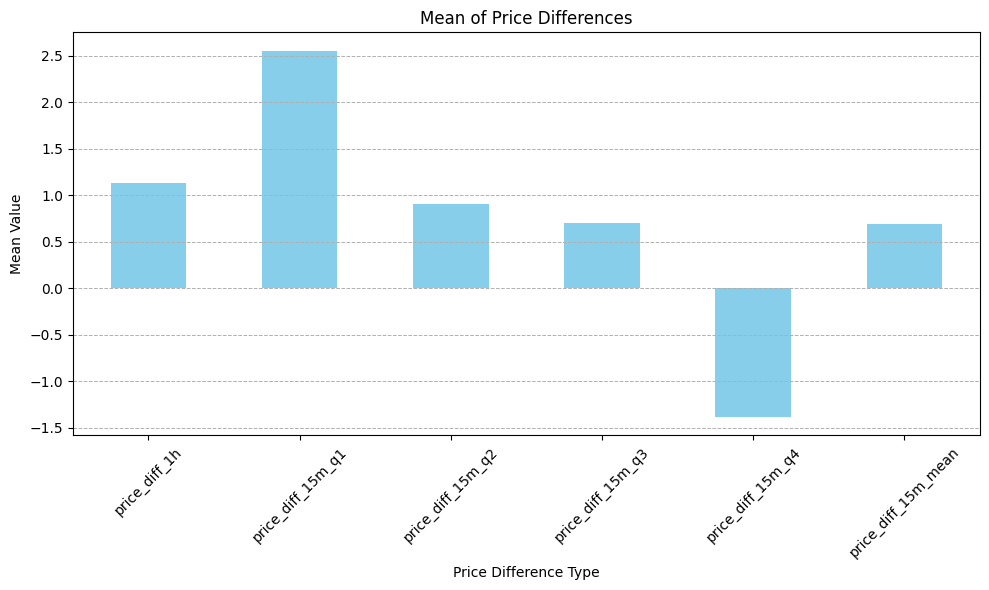

In [16]:
price_diff_means = df_hourly[[
    'price_diff_1h',
    'price_diff_15m_q1',
    'price_diff_15m_q2',
    'price_diff_15m_q3',
    'price_diff_15m_q4',
    'price_diff_15m_mean'
]].mean()

# Plot the means
plt.figure(figsize=(10, 6))
price_diff_means.plot(kind='bar', color='skyblue')
plt.title('Mean of Price Differences')
plt.xlabel('Price Difference Type')
plt.ylabel('Mean Value')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

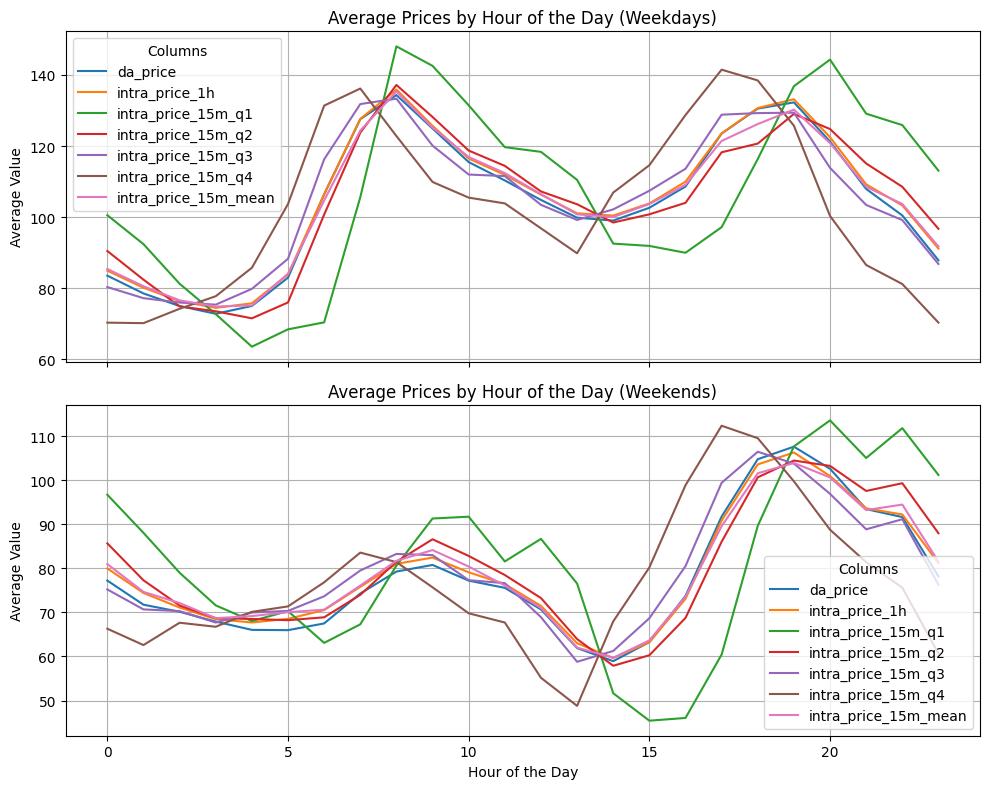

In [17]:
# Select weekday and weekend data
weekday_data = df_hourly[df_hourly['is_weekend'] == False]
weekend_data = df_hourly[df_hourly['is_weekend'] == True]

# Group by hour and calculate mean for each hour
weekday_hourly_avg = weekday_data[['da_price', 'intra_price_1h', 'intra_price_15m_q1', 'intra_price_15m_q2', 'intra_price_15m_q3', 'intra_price_15m_q4', 'intra_price_15m_mean']].groupby(weekday_data.index.hour).mean()
weekend_hourly_avg = weekend_data[['da_price', 'intra_price_1h', 'intra_price_15m_q1', 'intra_price_15m_q2', 'intra_price_15m_q3', 'intra_price_15m_q4', 'intra_price_15m_mean']].groupby(weekend_data.index.hour).mean()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Weekday plot
weekday_hourly_avg.plot(kind='line', ax=ax1)
ax1.set_title('Average Prices by Hour of the Day (Weekdays)')
ax1.set_ylabel('Average Value')
ax1.legend(title="Columns")
ax1.grid()

# Weekend plot
weekend_hourly_avg.plot(kind='line', ax=ax2)
ax2.set_title('Average Prices by Hour of the Day (Weekends)')
ax2.set_xlabel('Hour of the Day')
ax2.set_ylabel('Average Value')
ax2.legend(title="Columns")
ax2.grid()

plt.xticks(rotation=0)  # Keeps the hour labels horizontal
plt.tight_layout()
plt.show()

##### Diff 1h DA vs. Intra Price

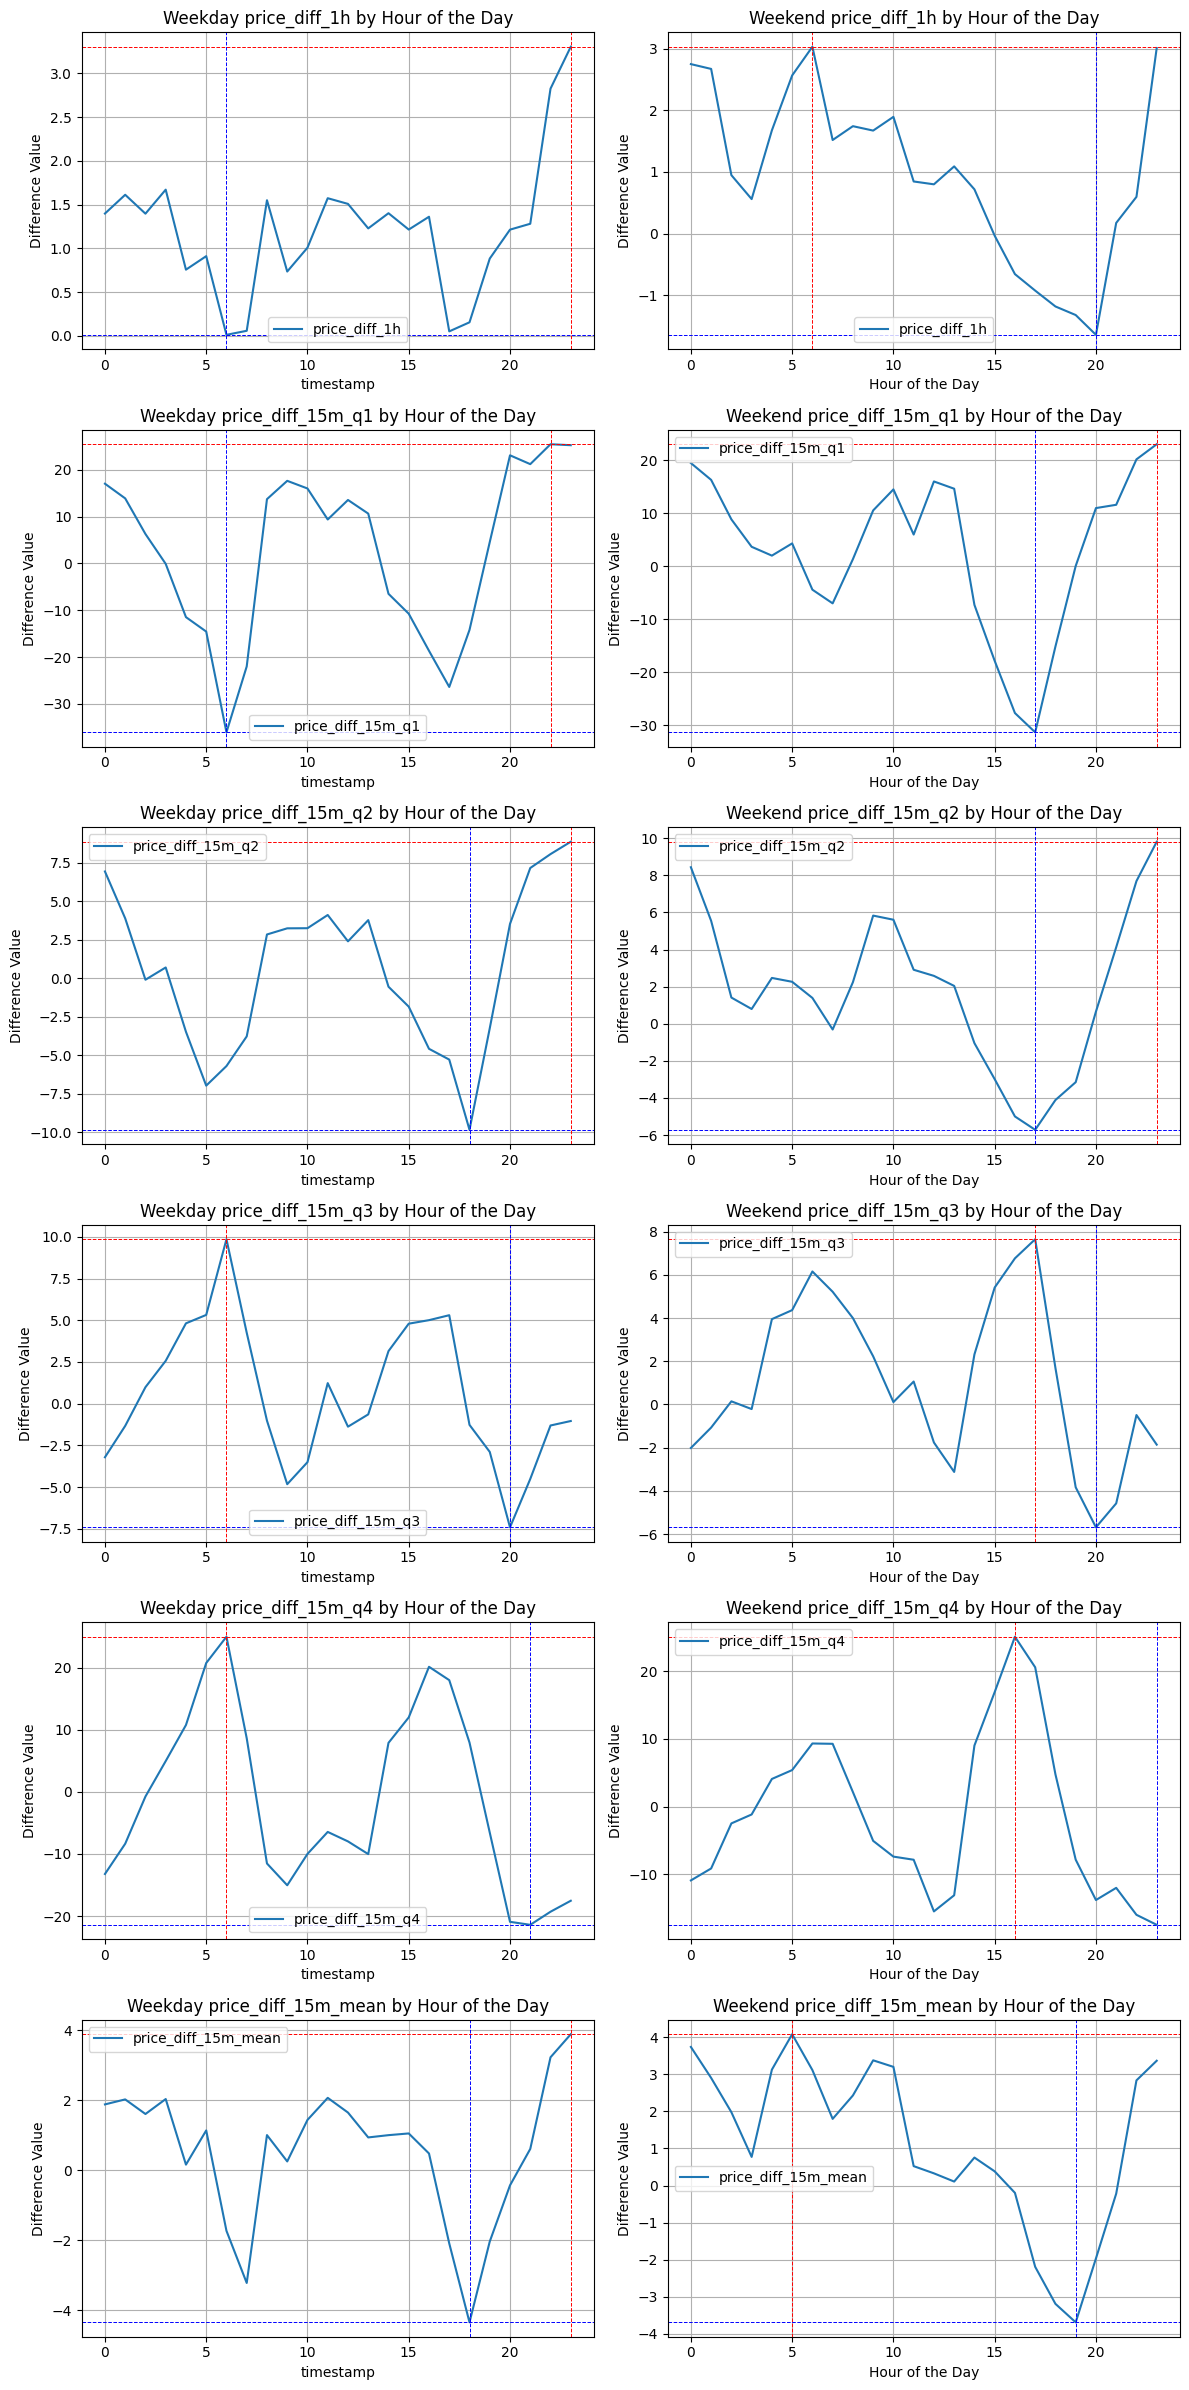

In [18]:
# List of columns to plot
columns = [
    'price_diff_1h',
    'price_diff_15m_q1',
    'price_diff_15m_q2',
    'price_diff_15m_q3',
    'price_diff_15m_q4',
    'price_diff_15m_mean'
]

weekday_diff_avg = weekday_data[columns].groupby(weekday_data.index.hour).mean()
weekend_diff_avg = weekend_data[columns].groupby(weekend_data.index.hour).mean()


# Plotting each column for weekdays and weekends
fig, axes = plt.subplots(len(columns), 2, figsize=(12, 4 * len(columns)), sharex=False)

for i, col in enumerate(columns):
    # Weekday plot
    weekday_diff_avg[[col]].plot(kind='line', ax=axes[i, 0])
    axes[i, 0].set_title(f'Weekday {col} by Hour of the Day')
    axes[i, 0].set_ylabel('Difference Value')
    axes[i, 0].legend([col])
    axes[i, 0].grid()

    # Find min and max values and their corresponding hours
    min_val_weekday = weekday_diff_avg[col].min()
    max_val_weekday = weekday_diff_avg[col].max()
    min_hour_weekday = weekday_diff_avg[col].idxmin()
    max_hour_weekday = weekday_diff_avg[col].idxmax()

    # Add horizontal and vertical lines for min and max
    axes[i, 0].axhline(min_val_weekday, color='blue', linestyle='--', linewidth=0.7)
    axes[i, 0].axhline(max_val_weekday, color='red', linestyle='--', linewidth=0.7)
    axes[i, 0].axvline(min_hour_weekday, color='blue', linestyle='--', linewidth=0.7)
    axes[i, 0].axvline(max_hour_weekday, color='red', linestyle='--', linewidth=0.7)

    # Weekend plot
    weekend_diff_avg[[col]].plot(kind='line', ax=axes[i, 1])
    axes[i, 1].set_title(f'Weekend {col} by Hour of the Day')
    axes[i, 1].set_xlabel('Hour of the Day')
    axes[i, 1].set_ylabel('Difference Value')
    axes[i, 1].legend([col])
    axes[i, 1].grid()

    # Find min and max values and their corresponding hours for weekend data
    min_val_weekend = weekend_diff_avg[col].min()
    max_val_weekend = weekend_diff_avg[col].max()
    min_hour_weekend = weekend_diff_avg[col].idxmin()
    max_hour_weekend = weekend_diff_avg[col].idxmax()

    # Add horizontal and vertical lines for min and max
    axes[i, 1].axhline(min_val_weekend, color='blue', linestyle='--', linewidth=0.7)
    axes[i, 1].axhline(max_val_weekend, color='red', linestyle='--', linewidth=0.7)
    axes[i, 1].axvline(min_hour_weekend, color='blue', linestyle='--', linewidth=0.7)
    axes[i, 1].axvline(max_hour_weekend, color='red', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()


##### Mean price diff for binned wind, pv and renew generation

In [19]:
# Ensure the output directory exists
output_dir = "/app/results/price_diff_gen_binned"
os.makedirs(output_dir, exist_ok=True)

# Define the different bin sizes and corresponding labels
bin_sizes = [1000, 2000, 5000]
bin_labels = ["1000-unit bins", "2000-unit bins", "5000-unit bins"]

# Columns to plot and their labels
price_diff_columns = [
    "price_diff_1h",
    "price_diff_15m_q1",
    "price_diff_15m_q2",
    "price_diff_15m_q3",
    "price_diff_15m_q4",
    "price_diff_15m_mean",
]
price_diff_labels = [
    "Mean Price Difference (1h)",
    "Mean Price Difference (15m Q1)",
    "Mean Price Difference (15m Q2)",
    "Mean Price Difference (15m Q3)",
    "Mean Price Difference (15m Q4)",
    "Mean Price Difference (15m Mean)",
]

# Define the sources of generation for binning
generation_sources = ["da_wind", "da_pv", "da_renew"]
source_labels = ["Wind", "PV", "Total Generation (Wind + PV)"]

# Loop through each generation source and create subplots for each price difference column
for source, source_label in zip(generation_sources, source_labels):
    fig, axes = plt.subplots(len(price_diff_columns), 1, figsize=(10, 4 * len(price_diff_columns)), sharex=False)

    for ax, col, col_label in zip(axes, price_diff_columns, price_diff_labels):
        for bin_size, bin_label in zip(bin_sizes, bin_labels):
            # Create bin edges and bin the data for the specified generation source
            bin_edges = np.arange(0, df_hourly[source].max() + bin_size, bin_size)
            df_hourly[f"{source}_bin"] = pd.cut(df_hourly[source], bins=bin_edges)
            binned_means = df_hourly.groupby(f"{source}_bin", observed=True)[col].mean()

            # Filter and prepare data for plotting
            bin_centers = [
                interval.mid for interval, mean in zip(binned_means.index, binned_means) if not np.isnan(mean)
            ]
            binned_means = binned_means.dropna()

            # Plot each line with a different bin size
            ax.plot(bin_centers, binned_means, label=bin_label)

        # Customize each subplot
        ax.set_xlabel(source_label)
        ax.set_ylabel(col_label)
        ax.set_title(f"{col_label} vs. Binned {source_label}")
        ax.grid()
        ax.legend()

    # Save the entire figure as one plot for each generation source
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"price_diff_{source}_binned_combined.png"))
    plt.close(fig)

# Drop all temporary bin columns after plotting
df_hourly.drop(columns=[f"{source}_bin" for source in generation_sources], inplace=True)

##### Mean price diff for binned wind, pv and renew generation ramps

In [20]:
# Ensure the output directory exists
output_dir = "/app/results/price_diff_gen_binned"
os.makedirs(output_dir, exist_ok=True)

# Define the different bin sizes and corresponding labels
bin_sizes = [500, 1000, 2000]
bin_labels = ["500-unit bins", "1000-unit bins", "2000-unit bins"]

# Columns to plot and their labels
price_diff_columns = [
    "price_diff_1h",
    "price_diff_15m_q1",
    "price_diff_15m_q2",
    "price_diff_15m_q3",
    "price_diff_15m_q4",
    "price_diff_15m_mean",
]
price_diff_labels = [
    "Mean Price Difference (1h)",
    "Mean Price Difference (15m Q1)",
    "Mean Price Difference (15m Q2)",
    "Mean Price Difference (15m Q3)",
    "Mean Price Difference (15m Q4)",
    "Mean Price Difference (15m Mean)",
]

# Define the sources of generation for binning
generation_sources = [
    "da_wind_ramp_in",
    "da_pv_ramp_in",
    "da_renew_ramp_in",
    "da_wind_ramp_out",
    "da_pv_ramp_out",
    "da_renew_ramp_out",
]
source_labels = [
    "Wind Ramp In",
    "PV Ramp In",
    "Total Generation Ramp In (Wind + PV)",
    "Wind Ramp Out",
    "PV Ramp Out",
    "Total Generation Ramp Out (Wind + PV)",
]

# Loop through each generation source and create subplots for each price difference column
for source, source_label in zip(generation_sources, source_labels):
    fig, axes = plt.subplots(len(price_diff_columns), 1, figsize=(10, 4 * len(price_diff_columns)), sharex=False)

    for ax, col, col_label in zip(axes, price_diff_columns, price_diff_labels):
        for bin_size, bin_label in zip(bin_sizes, bin_labels):
            # Create bin edges and bin the data for the specified generation source
            bin_edges = np.arange(df_hourly[source].min() - bin_size, df_hourly[source].max() + bin_size, bin_size)
            df_hourly[f"{source}_bin"] = pd.cut(df_hourly[source], bins=bin_edges)
            binned_means = df_hourly.groupby(f"{source}_bin", observed=True)[col].mean()

            # Filter and prepare data for plotting
            bin_centers = [
                interval.mid for interval, mean in zip(binned_means.index, binned_means) if not np.isnan(mean)
            ]
            binned_means = binned_means.dropna()

            # Plot each line with a different bin size
            ax.plot(bin_centers, binned_means, label=bin_label)

        # Customize each subplot
        ax.set_xlabel(source_label)
        ax.set_ylabel(col_label)
        ax.set_title(f"{col_label} vs. Binned {source_label}")
        ax.grid()
        ax.legend()

    # Save the entire figure as one plot for each generation source
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"price_diff_{source}_binned_combined.png"))
    plt.close(fig)

# Drop all temporary bin columns after plotting
df_hourly.drop(columns=[f"{source}_bin" for source in generation_sources], inplace=True)

#### Testing Framework

In [21]:
def test_strategy(price_diff, strategy_df, print_result=False, title=''):
    # Initialize total profit/loss and trade count
    total_profit_loss = 0.0
    trade_count = 0

    # Loop through each entry and apply the strategy
    for idx in strategy_df.index:
        action = strategy_df.loc[idx, 'strategy']
        
        # Select the appropriate price_diff based on action suffix
        if action == "buy_1h":
            price = price_diff.loc[idx, 'price_diff_1h']
            total_profit_loss += price * 100 # multiply by quantity 100 MW
            trade_count += 1
        elif action == "sell_1h":
            price = price_diff.loc[idx, 'price_diff_1h']
            total_profit_loss -= price * 100 # multiply by quantity 100 MW
            trade_count += 1
        elif action == "buy_15m":
            price = price_diff.loc[idx, 'price_diff_15m_mean']
            total_profit_loss += price * 100 # multiply by quantity 100 MW
            trade_count += 1
        elif action == "sell_15m":
            price = price_diff.loc[idx, 'price_diff_15m_mean']
            total_profit_loss -= price * 100 # multiply by quantity 100 MW
            trade_count += 1

    # Print results if print_result is True
    if print_result:
        print(f"Strategy: {title}")
        print(f"\tTotal Profit/Loss: {total_profit_loss / 1000:.0f}k EUR")
        print(f"\tTotal Trade Count: {trade_count}")
        print(f"\tMean Profit/Loss: {total_profit_loss / trade_count:.0f} EUR")
        print()
    else:
        # Return final profit/loss and total trade count
        return total_profit_loss, trade_count


#### Strategies


In [22]:
# Simple strategies

def always_buy_1h_strat(df):
    """
    Always buy the day-ahead market and sell it on the 1h intraday.
    """
    # Create a DataFrame with the same index as the input DataFrame, containing only the 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    # Set the 'strategy' column to always be "buy_1h"
    strategy_df['strategy'] = "buy_1h"
    
    return strategy_df

def simple_hour_1h_strat(df):
    """
    Buy and sell the hour of the day with the statistically highest mean return 
    for the 1h intraday.
    Selling is only done on weekends.
    """
    # Create an empty DataFrame with the same index as the input DataFrame, containing only the 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    # Apply the "buy" strategy at hour 23 on every day
    strategy_df.loc[df.index.hour == 23, 'strategy'] = "buy_1h"

    # Apply the "sell" strategy at hour 20, but only on weekends
    weekend_mask = df.index.weekday >= 5  # Saturday and Sunday have weekdays 5 and 6
    strategy_df.loc[(df.index.hour == 20) & weekend_mask, 'strategy'] = "sell_1h"
    
    return strategy_df

def simple_hour_15m_strat(df):
    """
    Buy and sell the hour of the day with the statistically highest mean return 
    for the 15m intraday.
    The best hour differs between weekdays and weekends.
    """
    # Create an empty DataFrame with the same index as the input DataFrame, containing only the 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    weekday_mask = df.index.weekday < 5  # Monday to Friday
    weekend_mask = df.index.weekday >= 5  # Saturday and Sunday

    # Weekday strategy: Buy at 23:00, Sell at 18:00
    strategy_df.loc[(df.index.hour == 23) & weekday_mask, 'strategy'] = "buy_15m"
    strategy_df.loc[(df.index.hour == 18) & weekday_mask, 'strategy'] = "sell_15m"

    # Weekend strategy: Buy at 5:00, Sell at 19:00
    strategy_df.loc[(df.index.hour == 5) & weekend_mask, 'strategy'] = "buy_15m"
    strategy_df.loc[(df.index.hour == 19) & weekend_mask, 'strategy'] = "sell_15m"

    return strategy_df


# Strategies based on wind generation

def buy_mid_high_wind_1h_strat(df):
    # Create an empty DataFrame with the same index as the input DataFrame, with only a 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    # Apply the "buy" strategy if da_wind is between 20,000 and 40,000 on any day
    strategy_df.loc[(df['da_wind'] >= 20000) & (df['da_wind'] <= 40000), 'strategy'] = "buy_1h"
    
    return strategy_df

def buy_mid_high_wind_15m_strat(df):
    # Create an empty DataFrame with the same index as the input DataFrame, with only a 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    # Apply the "buy" strategy if da_wind is between 20,000 and 40,000 on any day
    strategy_df.loc[(df['da_wind'] >= 20000) & (df['da_wind'] <= 40000), 'strategy'] = "buy_15m"
    
    return strategy_df


# Strategies based on wind generation ramps

def buy_high_wind_ramp_in_15m_thresh_strat(df, threshold):
    # Create an empty DataFrame with the same index as the input DataFrame, with only a 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    # Apply the "buy" strategy if da_wind is between 20,000 and 40,000 on any day
    strategy_df.loc[(df['da_wind_ramp_in'] >= threshold), 'strategy'] = "sell_15m"
    
    return strategy_df

def buy_high_wind_ramp_out_15m_thresh_strat(df, threshold):
    # Create an empty DataFrame with the same index as the input DataFrame, with only a 'strategy' column
    strategy_df = pd.DataFrame(index=df.index, columns=['strategy'])

    # Apply the "buy" strategy if da_wind is between 20,000 and 40,000 on any day
    strategy_df.loc[(df['da_wind_ramp_out'] >= threshold), 'strategy'] = "sell_15m"
    
    return strategy_df

In [23]:
# simple + hour based
print('Hour based Strategies')

test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    always_buy_1h_strat(df_hourly),
    print_result=True,
    title=f'Always buy'
)

test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    simple_hour_1h_strat(df_hourly),
    print_result=True,
    title=f'Hour based 1h'
)

test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    simple_hour_15m_strat(df_hourly),
    print_result=True,
    title=f'Hour based 15m'
)

Hour based Strategies
Strategy: Always buy
	Total Profit/Loss: 993k EUR
	Total Trade Count: 8755
	Mean Profit/Loss: 113 EUR

Strategy: Hour based 1h
	Total Profit/Loss: 134k EUR
	Total Trade Count: 468
	Mean Profit/Loss: 287 EUR

Strategy: Hour based 15m
	Total Profit/Loss: 295k EUR
	Total Trade Count: 729
	Mean Profit/Loss: 405 EUR



In [24]:
# wind gen
print('Wind Gen Strategies')

test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_mid_high_wind_1h_strat(df_hourly),
    print_result=True,
    title=f'Wind Gen 1h'
)

test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_mid_high_wind_15m_strat(df_hourly),
    print_result=True,
    title=f'Wind Gen 15m'
)

Wind Gen Strategies
Strategy: Wind Gen 1h
	Total Profit/Loss: 1169k EUR
	Total Trade Count: 1834
	Mean Profit/Loss: 637 EUR

Strategy: Wind Gen 15m
	Total Profit/Loss: 1145k EUR
	Total Trade Count: 1834
	Mean Profit/Loss: 624 EUR



In [25]:
# wind gen ramp
print('Wind Gen Ramp Strategies')

threshold = 2000
test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_high_wind_ramp_in_15m_thresh_strat(df_hourly, threshold),
    print_result=True,
    title=f'Wind Gen Ramp In 15m, theshold={threshold}'
)

threshold = 5000
test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_high_wind_ramp_in_15m_thresh_strat(df_hourly, threshold),
    print_result=True,
    title=f'Wind Gen Ramp In 15m, theshold={threshold}'
)

threshold = 2000
test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_high_wind_ramp_out_15m_thresh_strat(df_hourly, threshold),
    print_result=True,
    title=f'Wind Gen Ramp Out 15m, theshold={threshold}'
)

threshold = 3000
test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_high_wind_ramp_out_15m_thresh_strat(df_hourly, threshold),
    print_result=True,
    title=f'Wind Gen Ramp Out 15m, theshold={threshold}'
)

threshold = 5000
test_strategy(
    df_hourly[['price_diff_1h', 'price_diff_15m_mean']],
    buy_high_wind_ramp_out_15m_thresh_strat(df_hourly, threshold),
    print_result=True,
    title=f'Wind Gen Ramp Out 15m, theshold={threshold}'
)


Wind Gen Ramp Strategies
Strategy: Wind Gen Ramp In 15m, theshold=2000
	Total Profit/Loss: 129k EUR
	Total Trade Count: 228
	Mean Profit/Loss: 566 EUR

Strategy: Wind Gen Ramp In 15m, theshold=5000
	Total Profit/Loss: 8k EUR
	Total Trade Count: 6
	Mean Profit/Loss: 1272 EUR

Strategy: Wind Gen Ramp Out 15m, theshold=2000
	Total Profit/Loss: 153k EUR
	Total Trade Count: 228
	Mean Profit/Loss: 670 EUR

Strategy: Wind Gen Ramp Out 15m, theshold=3000
	Total Profit/Loss: 80k EUR
	Total Trade Count: 70
	Mean Profit/Loss: 1141 EUR

Strategy: Wind Gen Ramp Out 15m, theshold=5000
	Total Profit/Loss: 15k EUR
	Total Trade Count: 6
	Mean Profit/Loss: 2523 EUR

